<a href="https://www.kaggle.com/code/mohammedmohsen0404/proj24-cv-facial-expressions-prediction?scriptVersionId=193904511" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
**<center><h1>Facial Expressions</h1></center>**
<center><h3>Learning ML, DL through 100 Practical Projects</h3></center>

---

This project aims to develop a model for facial expression recognition using the FER-2013 dataset. The dataset consists of 48x48 pixel grayscale images of faces, with each face automatically registered to ensure consistency in size and positioning within the images.

# **Import Libraries and Data**
---

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense , InputLayer , Conv2D , MaxPooling2D , Dropout , Flatten , Input,concatenate,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.applications import DenseNet121 , ResNet50

In [3]:
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 96%|████████████████████████████████████▌ | 58.0M/60.3M [00:03<00:00, 28.3MB/s]
100%|██████████████████████████████████████| 60.3M/60.3M [00:03<00:00, 19.5MB/s]


# **Data Preparation**
----

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(48,48),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'

)

val_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(48,48),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(48,48),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Data Exploration**
----

In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Classes present in datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Classes present in datasets

0 : angry
1 : disgust
2 : fear
3 : happy
4 : neutral
5 : sad
6 : surprise


In [7]:
train_class_counts = dict(zip(train_generator.class_indices.keys(), np.bincount(train_generator.classes)))

print("Number of samples in each class (Training set):")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")


val_class_counts = dict(zip(val_generator.class_indices.keys(), np.bincount(val_generator.classes)))

print("\nNumber of samples in each class (Validation set):")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count}")


test_class_counts = dict(zip(test_generator.class_indices.keys(), np.bincount(test_generator.classes)))

print("\nNumber of samples in each class (Test set):")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")


Number of samples in each class (Training set):
angry: 3196
disgust: 349
fear: 3278
happy: 5772
neutral: 3972
sad: 3864
surprise: 2537

Number of samples in each class (Validation set):
angry: 799
disgust: 87
fear: 819
happy: 1443
neutral: 993
sad: 966
surprise: 634

Number of samples in each class (Test set):
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831


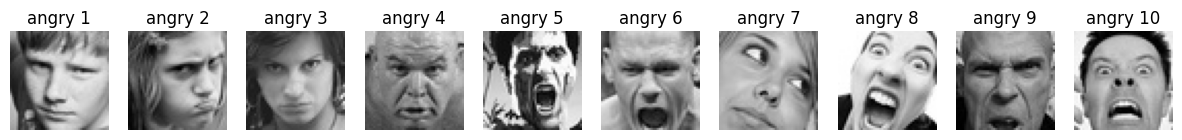

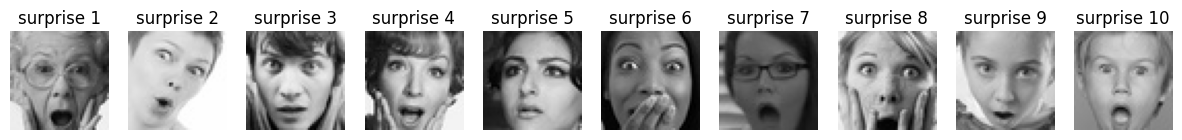

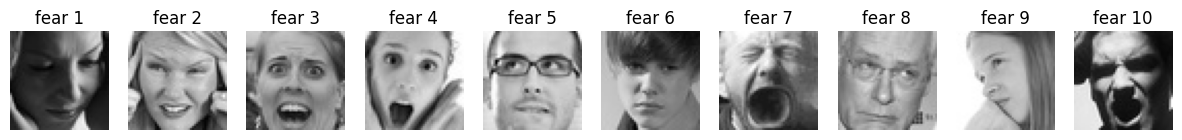

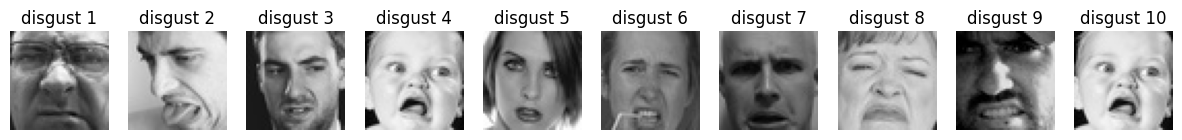

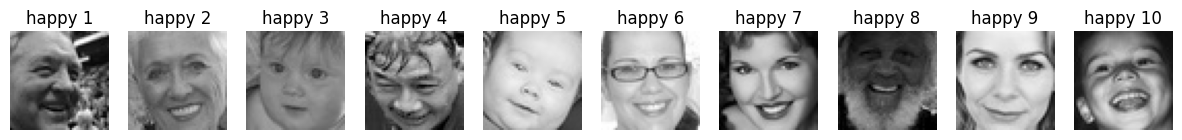

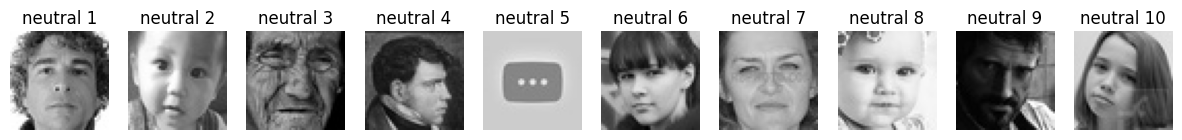

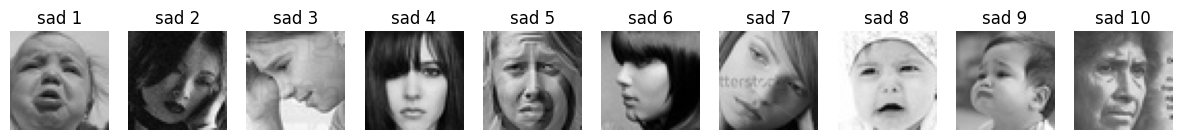

In [8]:
def display_images_by_class(parent_folder, n_images=10):
    class_folders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]

    for class_folder in class_folders:
        class_path = os.path.join(parent_folder, class_folder)
        images = os.listdir(class_path)[:n_images]
        plt.figure(figsize=(15, 10))
        for i, img_name in enumerate(images):
            img = load_img(os.path.join(class_path, img_name), target_size=(48, 48))
            plt.subplot(1, n_images, i + 1)
            plt.imshow(img)
            plt.title(f"{class_folder} {i+1}")
            plt.axis('off')
        plt.show()

parent_folder = 'train'

display_images_by_class(parent_folder, n_images=10)

# **Modeling**
----

In [9]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [10]:
class StandardizedConv2DWithOverride(Conv2D):
    def convolution_op(self, inputs, kernel):
        mean, var = tf.nn.moments(kernel, axes=[0, 1, 2], keepdims=True)
        return tf.nn.conv2d(
            inputs,
            (kernel - mean) / tf.sqrt(var + 1e-10),
            padding="VALID",
            strides=list(self.strides),
            name=self.__class__.__name__,
        )

In [11]:
# Inputs
input_layer = Input((48,48,3))

# Encoder
f1=StandardizedConv2DWithOverride(32, kernel_size=3, strides=3, padding='same', activation='relu')(input_layer)
f1=BatchNormalization()(f1)
f=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)
f2=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)


f1=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(f1)

f=concatenate([f,f1])
f=BatchNormalization()(f)

f1=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu',name='BeforeFinal_Layer')(f)
f=MaxPooling2D(2,2)(f)
f3=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)


f1=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(f1)

f=concatenate([f,f1,f2])
f=BatchNormalization()(f)
                    
f1=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)
f4=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)

f1=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(f1)
f1=BatchNormalization()(f1)

f=concatenate([f,f1,f3])

f1=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)


f1=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu')(f1)
f1=BatchNormalization()(f1)

f=concatenate([f,f1,f4])
#f=BatchNormalization()(f)
f=Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu', name='Final_Layer')(f)
#f=Conv2D(512, kernel_size=1, strides=2, padding='same', activation='relu')(f)
f=BatchNormalization()(f)
                    
f= Flatten()(f)
f=Dropout(rate=0.3)(f)
#f=BatchNormalization()(f)
f=Dense(1024, activation='relu')(f)
f=Dropout(rate=0.32)(f)
#f=BatchNormalization()(f)
output_layer=Dense(7, activation='softmax')(f)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ standardized_conv2… │ (None, 16, 16,    │        896 │ input_layer[0][0] │
│ (StandardizedConv2… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        128 │ standardized_con… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 8, 8, 32)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 32)  │      9,248 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 64)  │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │                   │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BeforeFinal_Layer   │ (None, 8, 8, 64)  │     36,928 │ conv2d_6[0][0]    │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 4, 4, 64)  │          0 │ BeforeFinal_Laye… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 32)  │      1,056 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4, 160) │          0 │ max_pooling2d_1[… │
│ (Concatenate)       │                   │            │ conv2d_9[0][0],   │
│                     │                   │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,188,135 (23.61 MB)

 Trainable params: 6,185,831 (23.60 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [12]:
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# model = Sequential()
# model.add(InputLayer(input_shape=(48, 48, 3)))
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(7, activation='softmax'))

# model.summary()

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
ES = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
RL = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [15]:
history = model.fit(train_generator,epochs=100,validation_data=val_generator,batch_size = 32, callbacks=[ES,RL],class_weight=class_weights)

Epoch 1/100


I0000 00:00:1724517475.839130     104 service.cc:145] XLA service 0x7aeb30002170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724517475.839194     104 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.1807 - loss: 0.7155

I0000 00:00:1724517485.332362     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


718/718 ━━━━━━━━━━━━━━━━━━━━ 66s 68ms/step - accuracy: 0.1422 - loss: 0.4712 - val_accuracy: 0.0357 - val_loss: 0.4412 - learning_rate: 0.0010
Epoch 2/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.1213 - loss: 0.4282 - val_accuracy: 0.1454 - val_loss: 0.4130 - learning_rate: 0.0010
Epoch 3/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.1321 - loss: 0.4172 - val_accuracy: 0.1707 - val_loss: 0.4087 - learning_rate: 0.0010
Epoch 4/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.1474 - loss: 0.4134 - val_accuracy: 0.1986 - val_loss: 0.3994 - learning_rate: 0.0010
Epoch 5/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.1832 - loss: 0.4035 - val_accuracy: 0.2698 - val_loss: 0.3961 - learning_rate: 0.0010
Epoch 6/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.2401 - loss: 0.3873 - val_accuracy: 0.2763 - val_loss: 0.3925 - learning_rate: 0.0010
Epoch 7/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.2635 - loss: 

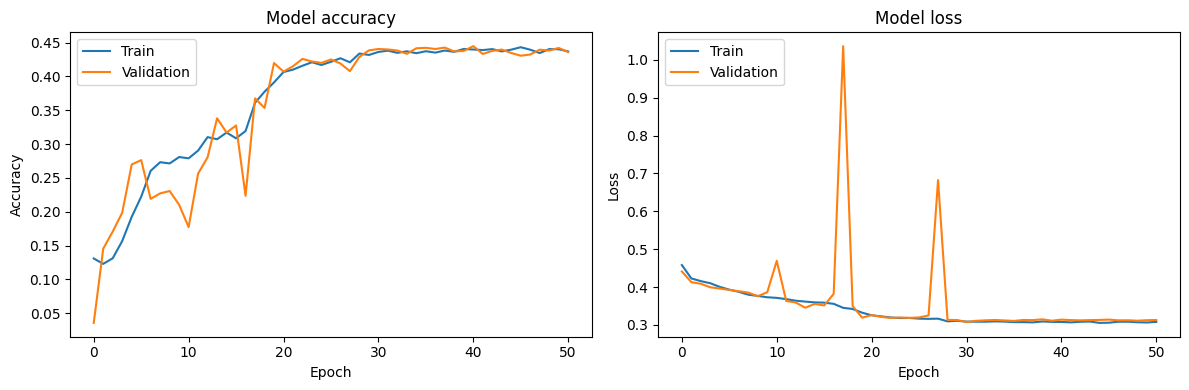

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# **Prediction**
----

In [17]:
loss,acc = model.evaluate(train_generator,batch_size = 32, verbose = 0)
print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

loss,acc = model.evaluate(test_generator,batch_size = 32, verbose = 0)
print('The accuracy of the model for test data is:',acc*100)
print('The Loss of the model for test data is:',loss)

The accuracy of the model for training data is: 45.332637429237366
The Loss of the model for training data is: 0.30324241518974304
The accuracy of the model for test data is: 45.84842622280121
The Loss of the model for test data is: 0.30189213156700134


In [18]:
predictions = model.predict(test_generator)
#y_pred = (predictions > 0.5).astype(int)
y_pred = np.argmax(predictions,axis = 1)
y_true = test_generator.classes

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


**Confusion Matrix**

In [19]:
#predictions = predictions.reshape(1,-1)[0]
cf_mtx = confusion_matrix(y_true,y_pred)
print(cf_mtx)

[[ 116  210    5   74  296  185   72]
 [  10   79    0    2    9    7    4]
 [  57  100    6   77  379  150  255]
 [   6   46    0 1407  150   73   92]
 [  41   37    8  139  704  185  119]
 [  71  102    9  142  539  313   71]
 [  13    6    6   35   88   17  666]]


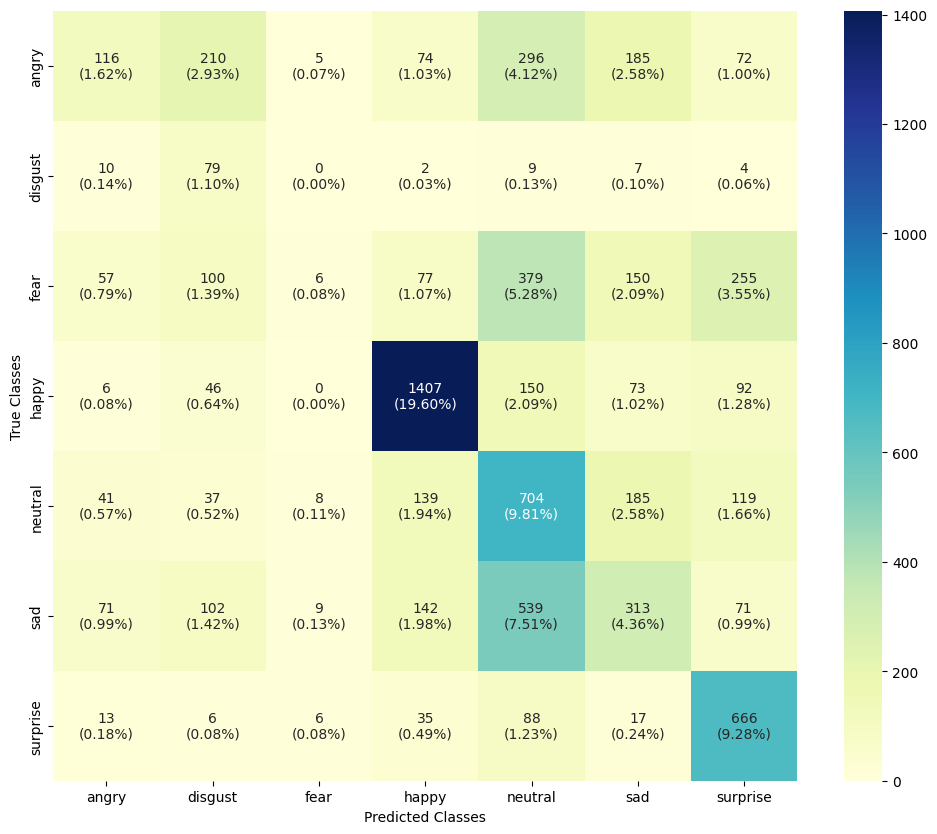

In [20]:
group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(7, 7)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

**Classification Report**

In [21]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

       angry       0.37      0.12      0.18       958
     disgust       0.14      0.71      0.23       111
        fear       0.18      0.01      0.01      1024
       happy       0.75      0.79      0.77      1774
     neutral       0.33      0.57      0.41      1233
         sad       0.34      0.25      0.29      1247
    surprise       0.52      0.80      0.63       831

    accuracy                           0.46      7178
   macro avg       0.37      0.47      0.36      7178
weighted avg       0.44      0.46      0.41      7178



**Display Some Images With Predictions**

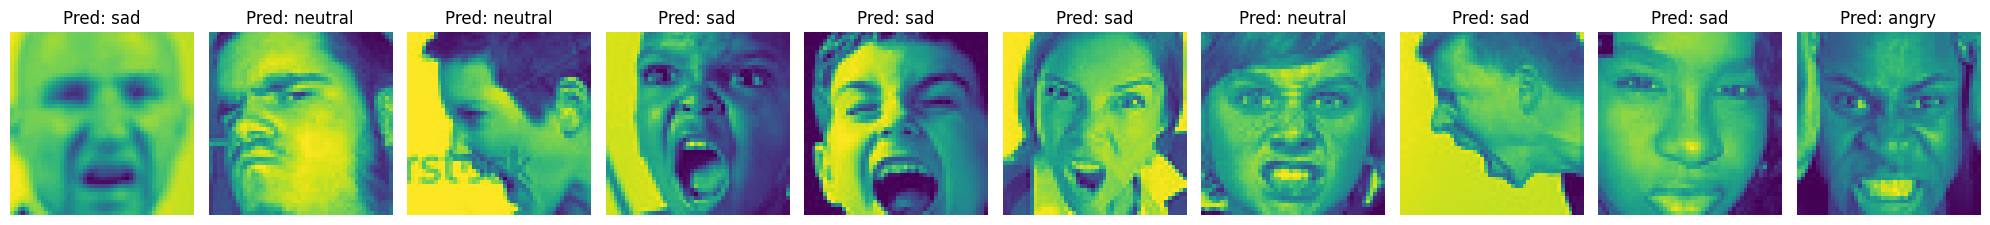

In [22]:
def display_images_with_predictions(generator, y_pred, num_images_to_display=10):
    # Get the class labels
    labels = {v: k for k, v in generator.class_indices.items()}

    # Get the filenames of the images
    filenames = generator.filenames

    # Create a subplot grid
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))

    for i in range(num_images_to_display):
        # Construct image path
        image_path = os.path.join(generator.directory, filenames[i])
        image = plt.imread(image_path)

        # Get predicted label
        predicted_label_idx = int(y_pred[i])
        predicted_label = labels[predicted_label_idx]

        # Display the image
        axes[i].imshow(image)
        axes[i].set_title(f"Pred: {predicted_label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


# Call the function
display_images_with_predictions(train_generator, y_pred, num_images_to_display=10)
